In [110]:
import pandas as pd  
import numpy as np
import xlrd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import *
from sklearn.metrics import *
from imblearn.over_sampling import SMOTE
#from google.colab import files
#uploaded = files.upload()
!pip install -U imbalanced-learn
!pip install -q pydot
!pip install -q graphviz
!apt-get install graphviz
!pip install treeinterpreter
!pip install keras
!pip install seaborn

Requirement already up-to-date: imbalanced-learn in /usr/local/lib/python3.6/dist-packages (0.6.2)
Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


In [111]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
sheet_name = "normal.csv"
path_real= "data/Physical/swat-attack-v0.xlsx"
path_test= "data/Physical/swat-normal-v0.xlsx"
path_collab="../content/drive/My Drive/swat-attack-v0.xlsx"
dataset = pd.read_excel(path_collab,skipinitialspace=True)

In [0]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    #classes=classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


In [0]:
dataset.columns = map(lambda s:s.strip(), dataset.columns)
categorical_cols=['MV101','P101','P102','MV201','P201','P202','P203','P204','P205','P206','MV301','MV302','MV303','MV304','P301','P302','P401','P402','P403','P404','UV401','P501','P502','P601','P602','P603']
for colname in categorical_cols:
  dataset[colname] = dataset[colname].astype('category')

for column in dataset.columns: #Label encoder
    if dataset[column].dtype == type(object):
        le = preprocessing.LabelEncoder()
        dataset[column] = le.fit_transform(dataset[column])
        
X = dataset.iloc[:, 1:52]  
y = dataset.iloc[:, 52]
#scaler = StandardScaler()
#X = scaler.fit_transform(X)
#y[2:10]


In [0]:
header = list()

for i in dataset.columns:
  if i not in ['Timestamp','Class']:
    header.append(i)

Scale data and do balanced rf

In [116]:
from imblearn.ensemble import BalancedRandomForestClassifier
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.31, random_state=0,stratify=y)  
instance = X_train.sample(n=50000).values #instance randomized to avoid RAM error
# Scale data (standardize it)
scaler.fit_transform(X_train)
scaler.transform(X_test)


array([[ 0.64,  2.06,  0.69, ...,  0.  , -0.1 ,  0.  ],
       [ 0.7 ,  1.3 ,  0.69, ...,  0.  , -0.1 ,  0.  ],
       [-1.44,  1.64, -1.38, ...,  0.  , -0.1 ,  0.  ],
       ...,
       [ 0.67, -0.85,  0.69, ...,  0.  , -0.1 ,  0.  ],
       [ 0.71, -0.87,  0.69, ...,  0.  , -0.1 ,  0.  ],
       [ 0.75, -0.78,  0.69, ...,  0.  , -0.1 ,  0.  ]])

In [117]:
from imblearn.metrics import classification_report_imbalanced
clf = BalancedRandomForestClassifier(max_depth=None, random_state=0,oob_score=True,n_estimators=100)
clf.fit(X_train,y_train)


y_pred = clf.predict(X_test)
y_pred= pd.DataFrame(y_pred)
print(classification_report_imbalanced(y_test, y_pred,     target_names=["0","1"]))

/usr/local/lib/python3.6/dist-packages/imblearn/ensemble/_forest.py:591: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      1.00      1.00      0.99      1.00      1.00     16933
          1       1.00      1.00      1.00      1.00      1.00      1.00    122542

avg / total       1.00      1.00      1.00      1.00      1.00      1.00    139475



In [118]:
clf_probs = clf.predict_proba(X_test)[:,1]
clf_probs0 = clf.predict_proba(X_test)[:,0]
print(roc_auc_score(y_test, clf_probs,average="weighted"))
print(roc_auc_score(y_test, clf_probs0,average="weighted"))

0.9999981426539019
1.8573460982275964e-06


Confusion matrix, without normalization
[[ 16933      0]
 [   184 122358]]


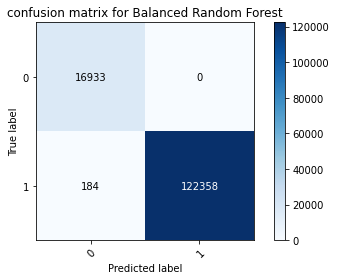

In [119]:
np.set_printoptions(precision=2)
from sklearn.utils.multiclass import unique_labels
#classes_spr = list(unique_labels(y_test, y_pred))
classes_spr = ["0","1"]
plot_confusion_matrix(y_test, y_pred, classes=classes_spr, normalize=False,
                      title='confusion matrix for Balanced Random Forest')
plt.show()

In [120]:
from treeinterpreter import treeinterpreter as ti
from collections import defaultdict 
import random
class1=defaultdict(list)
class2=defaultdict(list)
#instance = X_test.sample(n=50000).values #instance randomized to avoid RAM error
prediction, bias, contributions = ti.predict(clf, instance)
#print ("Prediction", prediction)
#print ("Bias (trainset prior)", bias)
print ("Feature contributions:")
test =list()
count = 0
for i in range(len(instance)):
  for c,feature in zip(contributions[i],header):
    #print (feature,c)
    fc_class1 = c[0]
    fc_class2=c[1]
    class1[feature].append(fc_class1)
    class2[feature].append(fc_class2)
  count+=1

#np.sum(contributions,axis=1)
print(count)

import statistics as sts
class1_fixed=list()
class2_fixed=list()
for header_name in header:
  array_value = class1[header_name]
  class2_array_value = class2[header_name]
  class1_fixed.append(sts.median(array_value))
  class2_fixed.append(sts.median(class2_array_value))

Feature contributions:
50000


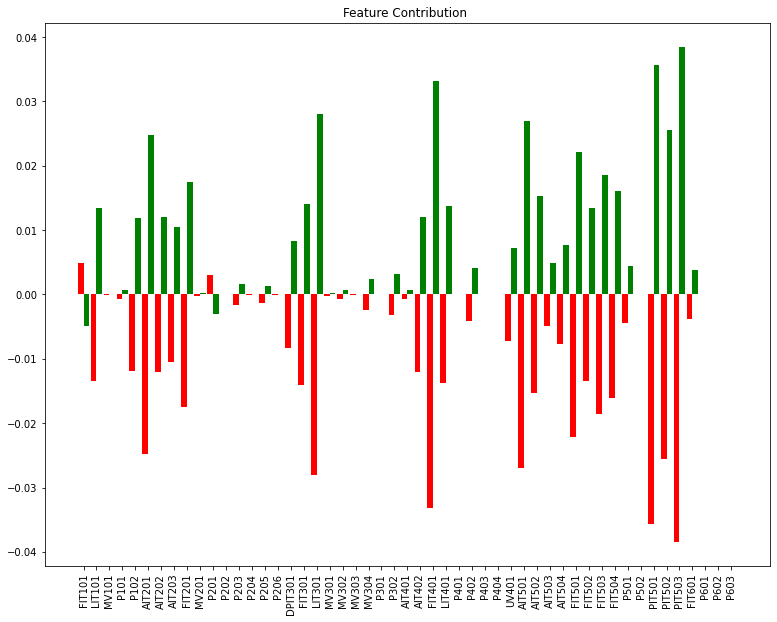

In [121]:
N= len(header)
fig, ax = plt.subplots(figsize=(13,10))
ind = np.arange(len(class1_fixed))   
width = 0.45
#fig.subplots_adjust(bottom=0.6)
p1 = ax.bar(ind, class1_fixed, width, color='red', bottom=0)
p2 = ax.bar(ind+width, class2_fixed, width, color='green', bottom=0)
ax.set_title('Feature Contribution ')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(header, rotation = 90)


plt.draw()
plt.savefig("fc1 standard balanced rf.png",dpi=100)
#files.download("fc1 standard balanced rf.png")
plt.show()
plt.close(fig)  

In [122]:
clf_rf = RandomForestClassifier(max_depth=None, random_state=1,oob_score=True,n_estimators=90,class_weight="balanced")
clf_rf.fit(X_train,y_train)  

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=90,
                       n_jobs=None, oob_score=True, random_state=1, verbose=0,
                       warm_start=False)

In [123]:
y_pred_rfsmote = pd.DataFrame(clf_rf.predict(X_test))
rf_probs = clf_rf.predict_proba(X_test)[:, 0]
rf_probs2 = clf_rf.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred_rfsmote, target_names=classes_spr))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16933
           1       1.00      1.00      1.00    122542

    accuracy                           1.00    139475
   macro avg       1.00      1.00      1.00    139475
weighted avg       1.00      1.00      1.00    139475



Confusion matrix, without normalization
[[ 16919     14]
 [    16 122526]]


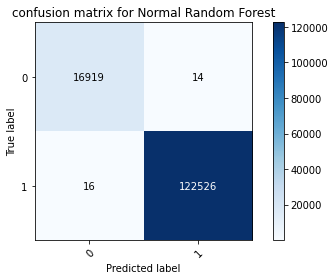

In [124]:
np.set_printoptions(precision=2)
from sklearn.utils.multiclass import unique_labels
#classes_spr = list(unique_labels(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred_rfsmote, classes=classes_spr, normalize=False,
                      title='confusion matrix for Normal Random Forest')
plt.show()

In [125]:
from treeinterpreter import treeinterpreter as ti
from collections import defaultdict 
import random
class1=defaultdict(list)
class2=defaultdict(list)
#instance = X_test.sample(n=50000).values #instance randomized to avoid RAM error
prediction, bias, contributions = ti.predict(clf_rf, instance)
#print ("Prediction", prediction)
#print ("Bias (trainset prior)", bias)
print ("Feature contributions:")
test =list()
count = 0
for i in range(len(instance)):
  for c,feature in zip(contributions[i],header):
    #print (feature,c)
    fc_class1 = c[0]
    fc_class2=c[1]
    class1[feature].append(fc_class1)
    class2[feature].append(fc_class2)
  count+=1

#np.sum(contributions,axis=1)
print(count)

import statistics as sts
class1_fixed=list()
class2_fixed=list()
for header_name in header:
  array_value = class1[header_name]
  class2_array_value = class2[header_name]
  class1_fixed.append(sts.median(array_value))
  class2_fixed.append(sts.median(class2_array_value))

Feature contributions:
50000


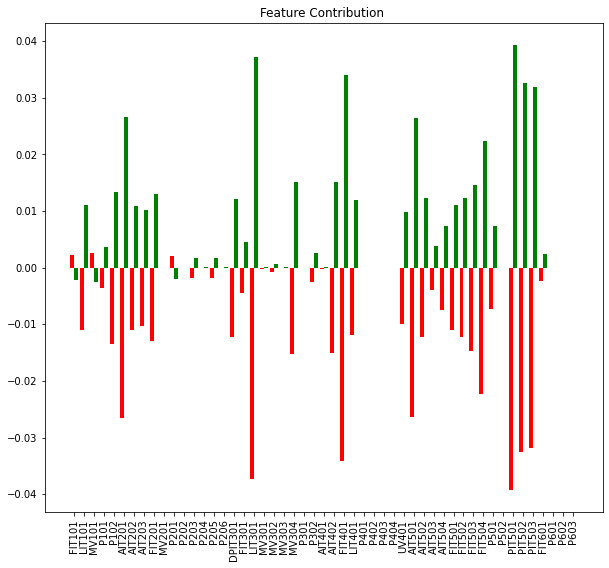

In [126]:
N= len(header)
fig, ax = plt.subplots(figsize=(10,9))
ind = np.arange(len(class1_fixed))   
width = 0.4

p1 = ax.bar(ind, class1_fixed, width, color='red', bottom=0)
p2 = ax.bar(ind+width, class2_fixed, width, color='green', bottom=0)
ax.set_title('Feature Contribution ')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(header, rotation = 90)


plt.draw()
plt.savefig("fc1 standard balanced rf.png",dpi=100)
#files.download("fc1 standard balanced rf.png")
plt.show()
plt.close(fig)  

In [127]:
print(classification_report(y_test, pd.DataFrame(y_pred_rfsmote), target_names=classes_spr))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16933
           1       1.00      1.00      1.00    122542

    accuracy                           1.00    139475
   macro avg       1.00      1.00      1.00    139475
weighted avg       1.00      1.00      1.00    139475



RF of tree 10, 50,100,1000

In [128]:
clf_rf10 = RandomForestClassifier(max_depth=None, random_state=1,oob_score=True,n_estimators=10,class_weight="balanced")
clf_rf10.fit(X_train,y_train) 



/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=True, random_state=1, verbose=0,
                       warm_start=False)

Metric for RF of tree size 10

In [129]:
y_pred_rf10= clf_rf10.predict(X_test)
print(classification_report(y_test, y_pred_rf10, target_names=classes_spr))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16933
           1       1.00      1.00      1.00    122542

    accuracy                           1.00    139475
   macro avg       1.00      1.00      1.00    139475
weighted avg       1.00      1.00      1.00    139475



Confusion matrix, without normalization
[[ 16915     18]
 [    14 122528]]


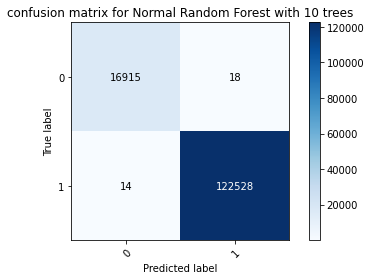

In [130]:
np.set_printoptions(precision=2)
from sklearn.utils.multiclass import unique_labels
classes_spr = list(unique_labels(y_test, y_pred_rf10))
plot_confusion_matrix(y_test, y_pred_rf10, classes=classes_spr, normalize=False,
                      title='confusion matrix for Normal Random Forest with 10 trees')
plt.show()

Feature contributions:
50000


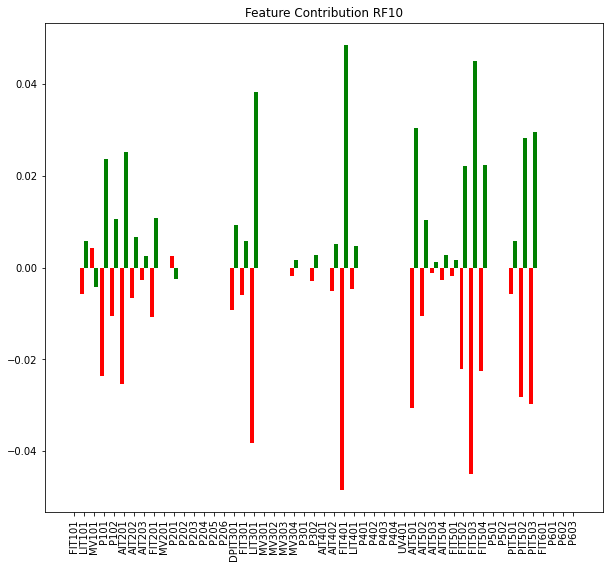

In [131]:
from treeinterpreter import treeinterpreter as ti
from collections import defaultdict 
import random
class1=defaultdict(list)
class2=defaultdict(list)
#instance = X_test.sample(n=50000).values #instance randomized to avoid RAM error
prediction, bias, contributions = ti.predict(clf_rf10, instance)
#print ("Prediction", prediction)
#print ("Bias (trainset prior)", bias)
print ("Feature contributions:")
test =list()
count = 0
for i in range(len(instance)):
  for c,feature in zip(contributions[i],header):
    #print (feature,c)
    fc_class1 = c[0]
    fc_class2=c[1]
    class1[feature].append(fc_class1)
    class2[feature].append(fc_class2)
  count+=1

#np.sum(contributions,axis=1)
print(count)

import statistics as sts
class1_fixed=list()
class2_fixed=list()
for header_name in header:
  array_value = class1[header_name]
  class2_array_value = class2[header_name]
  class1_fixed.append(sts.median(array_value))
  class2_fixed.append(sts.median(class2_array_value))
  
N= len(header)
fig, ax = plt.subplots(figsize=(10,9))
ind = np.arange(len(class1_fixed))   
width = 0.4

p1 = ax.bar(ind, class1_fixed, width, color='red', bottom=0)
p2 = ax.bar(ind+width, class2_fixed, width, color='green', bottom=0)
ax.set_title('Feature Contribution RF10')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(header, rotation = 90)


plt.draw()
plt.savefig("fc1 standard balanced rf.png",dpi=100)
#files.download("fc1 standard balanced rf.png")
plt.show()
plt.close(fig)    

RF with 50 trees

In [132]:
clf_rf50 = RandomForestClassifier(max_depth=None, random_state=1,oob_score=True,n_estimators=50,class_weight="balanced")
clf_rf50.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=True, random_state=1, verbose=0,
                       warm_start=False)

In [133]:
y_pred_rf50= clf_rf50.predict(X_test)
print(classification_report(y_test, pd.DataFrame(y_pred_rf50), target_names=["0","1"]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16933
           1       1.00      1.00      1.00    122542

    accuracy                           1.00    139475
   macro avg       1.00      1.00      1.00    139475
weighted avg       1.00      1.00      1.00    139475



Confusion matrix, without normalization
[[ 16917     16]
 [    16 122526]]


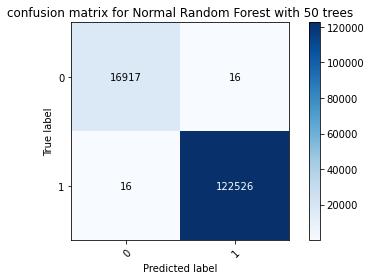

In [134]:
np.set_printoptions(precision=2)
from sklearn.utils.multiclass import unique_labels
classes_spr = list(unique_labels(y_test, y_pred_rf50))
plot_confusion_matrix(y_test, y_pred_rf50, classes=classes_spr, normalize=False,
                      title='confusion matrix for Normal Random Forest with 50 trees')
plt.show()

Feature contributions for rf50:
50000


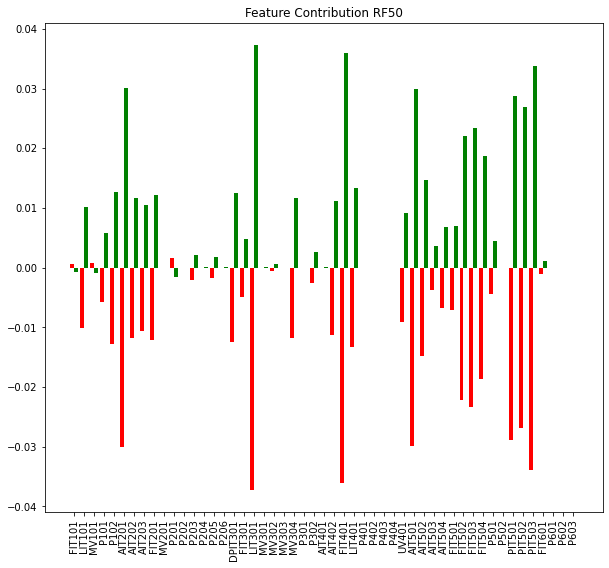

In [135]:
from treeinterpreter import treeinterpreter as ti
from collections import defaultdict 
import random
class1=defaultdict(list)
class2=defaultdict(list)
#instance = X_test.sample(n=50000).values #instance randomized to avoid RAM error
prediction, bias, contributions = ti.predict(clf_rf50, instance)
#print ("Prediction", prediction)
#print ("Bias (trainset prior)", bias)
print ("Feature contributions for rf50:")
test =list()
count = 0
for i in range(len(instance)):
  for c,feature in zip(contributions[i],header):
    #print (feature,c)
    fc_class1 = c[0]
    fc_class2=c[1]
    class1[feature].append(fc_class1)
    class2[feature].append(fc_class2)
  count+=1

#np.sum(contributions,axis=1)
print(count)

import statistics as sts
class1_fixed=list()
class2_fixed=list()
for header_name in header:
  array_value = class1[header_name]
  class2_array_value = class2[header_name]
  class1_fixed.append(sts.median(array_value))
  class2_fixed.append(sts.median(class2_array_value))
  
N= len(header)
fig, ax = plt.subplots(figsize=(10,9))
ind = np.arange(len(class1_fixed))   
width = 0.4

p1 = ax.bar(ind, class1_fixed, width, color='red', bottom=0)
p2 = ax.bar(ind+width, class2_fixed, width, color='green', bottom=0)
ax.set_title('Feature Contribution RF50')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(header, rotation = 90)


plt.draw()
plt.savefig("fc1 standard balanced rf.png",dpi=100)
#files.download("fc1 standard balanced rf.png")
plt.show()
plt.close(fig)   

RF for 100 trees

In [136]:
clf_rf100 = RandomForestClassifier(max_depth=None, random_state=1,oob_score=True,n_estimators=100,class_weight="balanced")
clf_rf100.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=1, verbose=0,
                       warm_start=False)

In [137]:
y_pred_rf100= clf_rf100.predict(X_test)
print(classification_report(y_test, pd.DataFrame(y_pred_rf100), target_names=["0","1"]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16933
           1       1.00      1.00      1.00    122542

    accuracy                           1.00    139475
   macro avg       1.00      1.00      1.00    139475
weighted avg       1.00      1.00      1.00    139475



Confusion matrix, without normalization
[[ 16919     14]
 [    17 122525]]


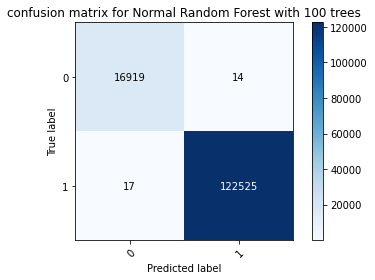

In [138]:
np.set_printoptions(precision=2)
from sklearn.utils.multiclass import unique_labels
#classes_spr = list(unique_labels(y_test, y_pred_rf100))
classes_spr=['0','1']
plot_confusion_matrix(y_test, y_pred_rf100, classes=classes_spr, normalize=False,
                      title='confusion matrix for Normal Random Forest with 100 trees')
plt.show()

Feature contributions for rf100:
50000


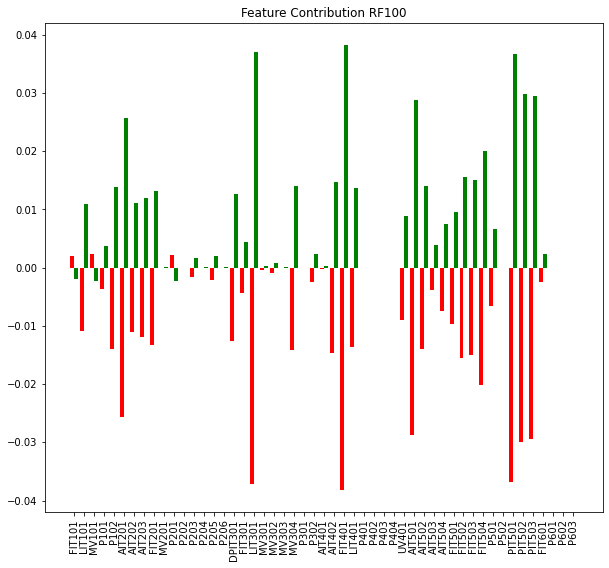

In [139]:
from treeinterpreter import treeinterpreter as ti
from collections import defaultdict 
import random
class1=defaultdict(list)
class2=defaultdict(list)
#instance = X_test.sample(n=50000).values #instance randomized to avoid RAM error
prediction, bias, contributions = ti.predict(clf_rf100, instance)
#print ("Prediction", prediction)
#print ("Bias (trainset prior)", bias)
print ("Feature contributions for rf100:")
test =list()
count = 0
for i in range(len(instance)):
  for c,feature in zip(contributions[i],header):
    #print (feature,c)
    fc_class1 = c[0]
    fc_class2=c[1]
    class1[feature].append(fc_class1)
    class2[feature].append(fc_class2)
  count+=1

#np.sum(contributions,axis=1)
print(count)

import statistics as sts
class1_fixed=list()
class2_fixed=list()
for header_name in header:
  array_value = class1[header_name]
  class2_array_value = class2[header_name]
  class1_fixed.append(sts.median(array_value))
  class2_fixed.append(sts.median(class2_array_value))
  
N= len(header)
fig, ax = plt.subplots(figsize=(10,9))
ind = np.arange(len(class1_fixed))   
width = 0.4

p1 = ax.bar(ind, class1_fixed, width, color='red', bottom=0)
p2 = ax.bar(ind+width, class2_fixed, width, color='green', bottom=0)
ax.set_title('Feature Contribution RF100')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(header, rotation = 90)


plt.draw()
plt.savefig("fc1 standard balanced rf.png",dpi=100)
#files.download("fc1 standard balanced rf.png")
plt.show()
plt.close(fig)   

RF with 500 trees

**SVM MODEL**

In [0]:

X_train_svm = scaler.fit_transform(X_train)
X_test_svm = scaler.fit_transform(X_test)

In [141]:
from sklearn.svm import *
svclassifier = LinearSVC(random_state=0,class_weight="balanced")
svclassifier.fit(X_train_svm, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
          verbose=0)

In [0]:
y_pred_svm = svclassifier.predict(X_test_svm)

In [143]:
print(confusion_matrix(y_test,y_pred_svm))
print(classification_report(y_test,y_pred_svm))


[[ 13614   3319]
 [  1558 120984]]
              precision    recall  f1-score   support

           0       0.90      0.80      0.85     16933
           1       0.97      0.99      0.98    122542

    accuracy                           0.97    139475
   macro avg       0.94      0.90      0.91    139475
weighted avg       0.96      0.97      0.96    139475



Confusion matrix, without normalization
[[ 13614   3319]
 [  1558 120984]]


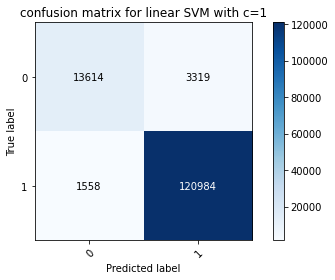

In [144]:
np.set_printoptions(precision=2)
from sklearn.utils.multiclass import unique_labels
classes_spr = list(unique_labels(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred_svm, classes=classes_spr, normalize=False,
                      title='confusion matrix for linear SVM with c=1')
plt.show()

In [145]:
testpd = pd.DataFrame(columns = header,rows=X)

TypeError: ignored

In [0]:
metricarr=list()
def iterforest(clf,i,metricarr):
  for i in range(i):
    clf_spec = RandomForestClassifier(max_depth=None, random_state=1,oob_score=True,n_estimators=10,class_weight="balanced")
    clf_spec.fit(X_train,y_train)
    y_pred_iter = pd.DataFrame(clf_rf.predict(X_test))
    #rf_probs = clf_rf.predict_proba(X_test)[:, 0]
    #rf_probs2 = clf_rf.predict_proba(X_test)[:, 1]
    
    print(classification_report(y_test, y_pred_iter, target_names=classes_spr))
    metricarr.append(classification_report(y_test, y_pred_iter, target_names=classes_spr))
    np.set_printoptions(precision=2)
    
    classes_spr = list(unique_labels(y_test, y_pred_rf50))
    plot_confusion_matrix(y_test, y_pred_rf50, classes=classes_spr, normalize=False,
                      title='confusion matrix for Normal Random Forest iteration '+i)
    plt.show()
    
    
    from treeinterpreter import treeinterpreter as ti
    from collections import defaultdict 
    import random
    class1=defaultdict(list)
    class2=defaultdict(list)
    #instance = X_test.sample(n=50000).values #instance randomized to avoid RAM error
    prediction, bias, contributions = ti.predict(clf_spec, instance)
    #print ("Prediction", prediction)
    #print ("Bias (trainset prior)", bias)
    print ("Feature contributions for rf100:")
    test =list()
    count = 0
    for i in range(len(instance)):
      for c,feature in zip(contributions[i],header):
        #print (feature,c)
        fc_class1 = c[0]
        fc_class2=c[1]
        class1[feature].append(fc_class1)
        class2[feature].append(fc_class2)
      count+=1

    #np.sum(contributions,axis=1)
    print(count)

    import statistics as sts
    class1_fixed=list()
    class2_fixed=list()
    for header_name in header:
      array_value = class1[header_name]
      class2_array_value = class2[header_name]
      class1_fixed.append(sts.median(array_value))
      class2_fixed.append(sts.median(class2_array_value))      
    for i in enumerate(class1_fixed):
      if class1_fixed[i] >0:
        setnum1=class1_fixed[i]
      if class2_fixed[i] >0:
        setnum1=class1_fixed[i]